In [1]:
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')

import  sc_preprocess


# general imports
import warnings
import numpy as np
import os
import pandas as pd
import scipy as sp
from scipy.sparse import coo_matrix
from scipy.optimize import nnls
import collections
import scanpy as sc
import anndata

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import sklearn as sk
from sklearn.preprocessing import scale
import scipy.sparse as sp
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

import pickle
import gzip
from pathlib import Path

In [2]:
# parameters

aug_data_path = f"{os.getcwd()}/out/"
cybersort_path = f"{os.getcwd()}/../data/single_cell_data/cybersort_pbmc/"
data_path = f"{os.getcwd()}/../data/single_cell_data/pbmc6k/hg19/"
scpred_path = f"{os.getcwd()}/../results/single_cell_data/pbmc_cell_labels/"


num_cells_vec = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
num_cells_vec = [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]


#####################
### set the study ###
#####################

res_name = "pbmc6k"
results_file = f"{data_path}/{res_name}.h5ad"
results_file

'/projects/ssadeeq@xsede.org/rotation3/sc_bulk_ood/sc_preprocessing1/bulk/../data/single_cell_data/pbmc6k/hg19//pbmc6k.h5ad'

In [5]:
# read in the data
adata = sc.read('/scratch/alpine/ssadeeq@xsede.org/rotation3/scRNA-seq/Hs10X.h5ad')

In [6]:
barcodes = pd.DataFrame({"cell_id": adata.obs.index})

In [7]:
barcodes

,cell_id
0,Hs_OAT_254-1_GAGTTGTGTATAGGGC
1,Hs_OAT_13-1_GAACGTTTCGTTACCC
2,Hs_OAT_254-1_ATCACTTGTTCAGGTT
3,Hs_SAT_01-1_TCTCAGCTCTTCCCGA
4,Hs_SAT_266-1_CTTCCTTCACGCTGTG
...,...
68837,Hs_SAT_266-1_ATTCATCCAGAGAAAG
68838,Hs_SAT_12-1_ATTCTTGAGTCTGCAT
68839,Hs_OAT_10-1_GCTGCAGCAGTTGGTT
68840,Hs_SAT_254-1_TTGCCTGAGCGCCATC


In [8]:
meta_data = pd.read_csv("/scratch/alpine/ssadeeq@xsede.org/rotation3/scRNA-seq//metadata.tsv.gz", sep="\t")
#barcodes = pd.read_csv("/scratch/alpine/ssadeeq@xsede.org/rotation3/scRNA-seq//barcodes.tsv.gz", sep="\t"
meta_df = pd.merge(barcodes, meta_data, on='cell_id')
meta_data.head()

/tmp/ipykernel_3168098/2747064202.py:1: DtypeWarning: Columns (19,20,21,22,23,24,30,32,33,36,37,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_data = pd.read_csv("/scratch/alpine/ssadeeq@xsede.org/rotation3/scRNA-seq//metadata.tsv.gz", sep="\t")


,cell_id,biosample_id,biosample_type,library_preparation_protocol__ontology_id,library_preparation_protocol__ontology_label,donor_id,species__ontology_id,species__ontology_label,organ__ontology_id,organ__ontology_label,...,ribosomal_protein_percent,sct__n_umis,sct__n_genes,cell_cycle__s_score,cell_cycle__g2m_score,cell_cycle__phase,cell_type__ontology_id,cell_type__ontology_label,cell_type__custom,cell_subtype__custom
0,Hs_OAT_01-1_AAACCCAAGCAAGGAA,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.320758,5042,3178,0.013315,-0.002799,S,CL:0000077,mesothelial cell,mesothelium,hMes1
1,Hs_OAT_01-1_AAACCCAAGGGTGGGA,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.489574,4905,2578,-0.051260,-0.012629,G1,CL:0000235,macrophage,macrophage,hMac3
2,Hs_OAT_01-1_AAACCCAAGTCTGGAG,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.599401,3607,1808,0.046359,-0.009526,S,CL:0000235,macrophage,macrophage,hMac1
3,Hs_OAT_01-1_AAACCCACAGCCCAGT,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.420800,5029,3041,0.018981,0.021519,G2M,CL:0000077,mesothelial cell,mesothelium,hMes3
4,Hs_OAT_01-1_AAACCCACATCTTCGC,Hs_OAT_01-1,PrimaryBioSample_Tissue,EFO:0009922,10x 3' v3 sequencing,TP01,NCBITaxon:9606,Homo sapiens,UBERON:0001013,adipose tissue,...,0.166098,4776,2539,0.028879,-0.005132,S,CL:0000136,fat cell,adipocyte,hAd2


In [9]:
adata.obs['CellType'] = meta_df['cell_type__ontology_label'].tolist()

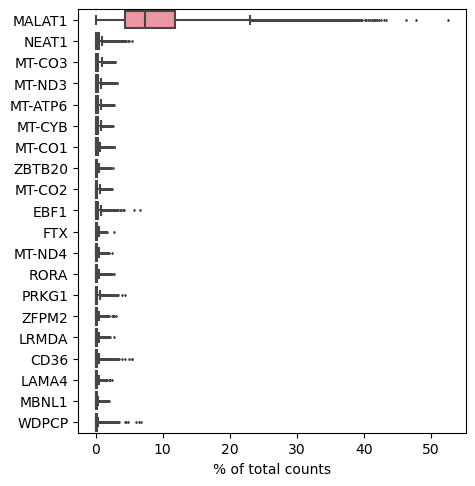

In [10]:
sc.pl.highest_expr_genes(adata, n_top=20, )

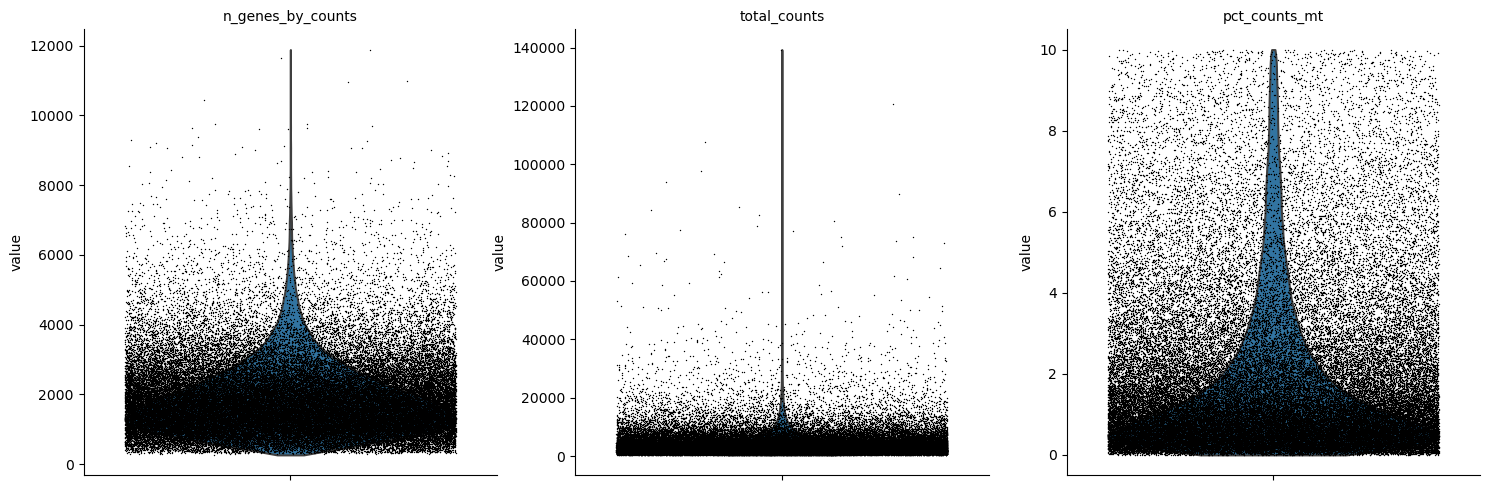

In [11]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

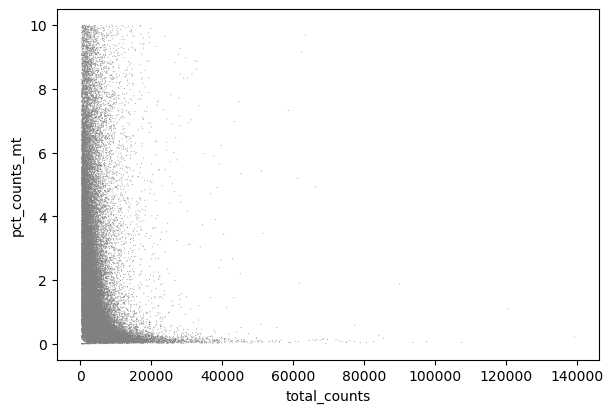

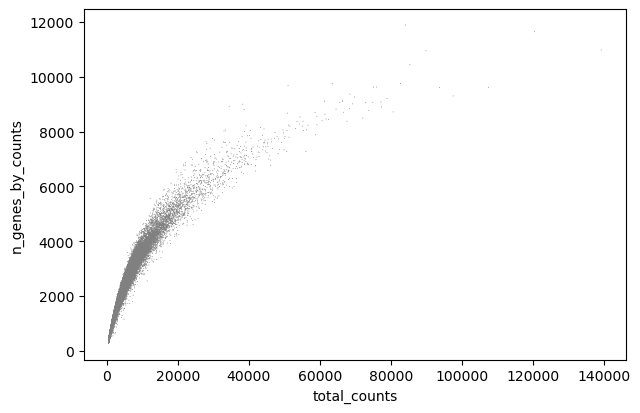

In [12]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')


In [13]:

adata = adata[adata.obs.n_genes_by_counts < 8000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]

# normalize to 10K counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

/projects/ssadeeq@xsede.org/software/anaconda/envs/tf_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [14]:
adata

AnnData object with n_obs × n_vars = 68777 × 29093
    obs: 'CellType', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [15]:
# group together cell types that are not very frequent
adata.obs["CellType"]


Hs_OAT_254-1_GAGTTGTGTATAGGGC        preadipocyte
Hs_OAT_13-1_GAACGTTTCGTTACCC         preadipocyte
Hs_OAT_254-1_ATCACTTGTTCAGGTT          macrophage
Hs_SAT_01-1_TCTCAGCTCTTCCCGA         preadipocyte
Hs_SAT_266-1_CTTCCTTCACGCTGTG            fat cell
                                       ...       
Hs_OAT_09-1_AAGCCATAGCAGTAAT     mesothelial cell
Hs_SAT_12-1_ATTCTTGAGTCTGCAT         preadipocyte
Hs_OAT_10-1_GCTGCAGCAGTTGGTT     mesothelial cell
Hs_SAT_254-1_TTGCCTGAGCGCCATC          macrophage
Hs_SAT_266-1_TTCCTTCCAACGTATC            fat cell
Name: CellType, Length: 68777, dtype: category
Categories (16, object): ['B cell', 'T cell', 'dendritic cell', 'endothelial cell', ..., 'pericyte cell', 'preadipocyte', 'smooth muscle cell', 'stromal cell of endometrium']

In [16]:
# group together cell types that are not very frequent

all_vals = adata.obs["CellType"].to_list()
all_vals = np.char.replace(all_vals, 'adc', 'other')
all_vals = np.char.replace(all_vals, 'pdc', 'other')
all_vals = np.char.replace(all_vals, 'mk', 'other')
all_vals = np.char.replace(all_vals, 'hsc', 'other')
adata.obs["CellType"] = all_vals

from collections import Counter
Counter(all_vals)


Counter({'preadipocyte': 15581,
         'macrophage': 8410,
         'fat cell': 12926,
         'smooth muscle cell': 1415,
         'mesothelial cell': 15207,
         'stromal cell of endometrium': 172,
         'immature NK T cell': 983,
         'mast cell': 532,
         'endothelial cell of lymphatic vessel': 1358,
         'endothelial cell': 7366,
         'T cell': 2744,
         'monocyte': 599,
         'B cell': 190,
         'dendritic cell': 520,
         'pericyte cell': 698,
         'neutrophil': 76})

In [35]:
# Perform dimensionality reduction using principal component analysis (PCA)
sc.pp.normalize_total(adata)  # normalize the expression data
sc.pp.log1p(adata)            # log-transform the data
sc.pp.highly_variable_genes(adata)  # identify highly variable genes
sc.pp.pca(adata, n_comps=50, use_highly_variable=True)  # run PCA

# Perform clustering on the PCA-reduced data
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)  # calculate neighborhood graph
sc.tl.leiden(adata)  # cluster cells using the Leiden algorithm
#sc.pl.umap(adata, color=['leiden'])  # plot UMAP with cell clusters colored

2023-04-06 11:53:10.806174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


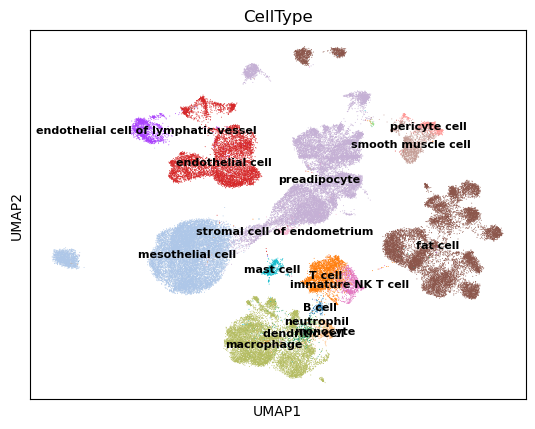

In [36]:
# valculate neighborhood graph
sc.pp.neighbors(adata)
# make umap
sc.tl.umap(adata)
# plot some markers of the RAW data
sc.pl.umap(adata, legend_loc='on data', color='CellType', legend_fontsize=8)

In [5]:
adata_df=adata.to_df()

In [6]:
adata_df.head()

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,ULBP1,WTH3DI,XIRP1,Z82196.2,Z84488.1,Z99755.2,Z99916.3,ZNF280A,ZPBP2,CD99.Y
Hs_OAT_254-1_GAGTTGTGTATAGGGC,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hs_OAT_13-1_GAACGTTTCGTTACCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hs_OAT_254-1_ATCACTTGTTCAGGTT,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hs_SAT_01-1_TCTCAGCTCTTCCCGA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hs_SAT_266-1_CTTCCTTCACGCTGTG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
len_vector = adata.obs["CellType"].unique().shape[0]
cell_noise = [np.random.lognormal(0, 0, adata.var['gene_ids'].shape[0]) for i in range(len_vector)]

# make b-cells be perturbed -- this will be used for unlabeled
cell_noise_perturb = cell_noise
cell_noise_perturb[0] = np.random.lognormal(0, 0.7, adata.var['gene_ids'].shape[0])

In [19]:
# write out the gene ids
gene_pass = adata.var['gene_ids']
gene_out_file = os.path.join(aug_data_path, f"{res_name}_genes.pkl")
gene_out_path = Path(gene_out_file)
pickle.dump( gene_pass, open( gene_out_path, "wb" ) )

In [23]:
#Cell type proportion
rand_vec = adata.obs["CellType"].value_counts() / adata.obs["CellType"].shape[0]
rand_vec = np.array(rand_vec)
rand_vec
#np.round(rand_vec*num_cells)

array([0.22654376, 0.22110589, 0.18794074, 0.12227925, 0.10709976,
       0.03989706, 0.02057374, 0.01974497, 0.01429257, 0.01014874,
       0.00870931, 0.00773514, 0.00756067, 0.00276255, 0.00250084,
       0.00110502])

### Pseeudobulks

In [24]:
# simulate different number of cells
num_samples = 1000
for idx in range(len(num_cells_vec)):
  print(f"New Domain {idx}")
  pbmc_rep1_pseudobulk_file = os.path.join(aug_data_path, f"{res_name}bulk_pseudo_{idx}.pkl")
  pbmc_rep1_prop_file = os.path.join(aug_data_path, f"{res_name}bulk_prop_{idx}.pkl")
  test_pbmc_rep1_pseudobulk_file = os.path.join(aug_data_path, f"{res_name}bulk_testpseudo_{idx}.pkl")
  test_pbmc_rep1_prop_file = os.path.join(aug_data_path, f"{res_name}bulk_testprop_{idx}.pkl")

  # if unlabeled data, we need to have both perturbed and non-perturbed cell types
  # idx 0 is for testing and will be perturbed
  # idx 1-4 are not perturbed because they are labeled
  # idx 5 is ignored for now, we will make it perturbed
  # idx 6-9 are unlabeled and will have be perturbed half not be
  # so this makes idx 5,6,7 perturbed
  # idx 8,9 unperturbed
  # summary:
  # perturbed: 0,5,6,7
  # unperturb: 1,2,3,4,8,9
  # train: 1,2,3,4,6,7,8,9
  # test:  0
  # labeled: 1,2,3,4
  # unlabeled: 6,7,8,9

  #perturbed_idx = np.array([0,5,6,7])
  cell_noise_choice = cell_noise
  #if idx in perturbed_idx:
  #  cell_noise_choice = cell_noise_perturb

  pseudobulk_path = Path(pbmc_rep1_pseudobulk_file)
  prop_path = Path(pbmc_rep1_prop_file)
  test_pseudobulk_path = Path(test_pbmc_rep1_pseudobulk_file)
  test_prop_path = Path(test_pbmc_rep1_prop_file)

  if not pseudobulk_path.is_file(): # skip if we already generated it
    # make the pseudobulks
    num_cells = num_cells_vec[idx]
    prop_df, pseudobulks_df, test_prop_df, test_pseudobulks_df = sc_preprocess.make_prop_and_sum(adata, 
                                                                            num_samples, 
                                                                            num_cells,
                                                                            use_true_prop=False,
                                                                            cell_noise=cell_noise_choice)

    # make the proportions instead of cell counts
    prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
    test_prop_df = test_prop_df.div(test_prop_df.sum(axis=1), axis=0)

    pickle.dump( prop_df, open( prop_path, "wb" ) )
    pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )

    pickle.dump( test_prop_df, open( test_prop_path, "wb" ) )
    pickle.dump( test_pseudobulks_df, open( test_pseudobulk_path, "wb" ) )


    if not np.all(np.isclose(prop_df.sum(axis=1), 1.)):
        assert False, "Proportions do not sum to 1"

New Domain 0
New Domain 1
New Domain 2
New Domain 3
New Domain 4
New Domain 5
New Domain 6
New Domain 7
New Domain 8
New Domain 9


### Dumping and Loading

In [19]:
#Save processed adata
adata_file = os.path.join(aug_data_path, f"{res_name}_processed_ref_adata.pkl")
adata_path = Path(adata_file)
pickle.dump(adata, open(adata_path, "wb" ) )

In [12]:
with open(f'{aug_data_path}/pbmc6k_processed_ref_adata.pkl', 'rb') as f:
    # Load the Python object from the .pkl file
    adata = pickle.load(f)

In [ ]:
##Read pseudobulks smaples from path
pseudobulks = pd.DataFrame(columns = adata.var['gene_ids'])
for  i in range(10):
    with open(f'{aug_data_path}/pbmc6kbulk_pseudo_{i}.pkl', 'rb') as f:
        # Load the Python object from the .pkl file
        pseudobulk = pickle.load(f)
    #plt.imshow(pseudobulks, cmap='viridis', aspect='auto')
    pseudobulk["samples"] = np.full(pseudobulk.shape[0], f"sample {i}")
    pseudobulks = pd.concat([pseudobulks, pseudobulk])
pseudobulks["samples"] = pseudobulks['samples'].astype('category')


In [23]:
#Save pseudobulks output
pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_pseudobulk_samples.pkl")
pseudobulk_path = Path(pseudobulk_file)
pickle.dump(pseudobulks, open(pseudobulk_path, "wb" ) )

In [7]:
with open(f'{aug_data_path}/pbmc6k_pseudobulk_samples.pkl', 'rb') as f:
    # Load the Python object from the .pkl file
    pseudobulk_df = pickle.load(f)
pseudobulk_df.tail(5)    

gene_ids,ENSG00000121410.11,ENSG00000268895.5,ENSG00000148584.14,ENSG00000175899.14,ENSG00000245105.2,ENSG00000166535.19,ENSG00000256661.1,ENSG00000184389.9,ENSG00000128274.15,ENSG00000118017.3,...,ENSG00000233087.7,ENSG00000168334.8,ENSG00000237316.1,ENSG00000244158.1,ENSG00000273068.1,ENSG00000279298.1,ENSG00000169548.3,ENSG00000186075.12,ENSG00000002586.18_PAR_Y,samples
0,34,610,3,1785,500,98,143,9,216,4,...,0,0,0,0,0,0,0,0,0,sample 9
0,107,620,19,1597,139,38,385,19,389,0,...,0,0,0,0,0,0,0,0,0,sample 9
0,14,126,1,1923,319,26,174,17,102,1,...,0,0,0,0,0,0,0,0,0,sample 9
0,23,208,20,1959,413,90,322,13,101,5,...,0,0,0,0,0,0,0,0,0,sample 9
0,22,276,4,3830,245,60,280,7,195,3,...,0,0,0,0,0,0,0,0,0,sample 9


In [10]:
# Proportion
cell_props = pd.DataFrame(columns = adata.obs["CellType"].unique())
for  i in range(10):
    with open(f'{aug_data_path}/pbmc6kbulk_prop_{i}.pkl', 'rb') as f:
        # Load the Python object from the .pkl file
        cell_prop = pickle.load(f)
    cell_props = pd.concat([cell_props, cell_prop])
mx_prop = cell_prop.columns[np.argmax(cell_props.to_numpy(), axis=1)]

In [39]:
cell_props.head()

,preadipocyte,macrophage,fat cell,smooth muscle cell,mesothelial cell,stromal cell of endometrium,immature NK T cell,mast cell,endothelial cell of lymphatic vessel,endothelial cell,T cell,monocyte,B cell,dendritic cell,pericyte cell,neutrophil
0,0.057,0.0032,0.0184,0.0118,0.1366,0.015,0.0008,0.036,0.0028,0.0164,0.2594,0.0414,0.0208,0.0178,0.359,0.0036
0,0.0256,0.369,0.001,0.001,0.0004,0.0098,0.0012,0.0006,0.495,0.0028,0.0024,0.0714,0.0106,0.0056,0.0,0.0036
0,0.024,0.0036,0.039,0.3024,0.0252,0.051,0.0116,0.1412,0.0182,0.058,0.0196,0.1138,0.0364,0.0034,0.1156,0.037
0,0.0028,0.0004,0.0524,0.0672,0.0648,0.4058,0.0604,0.1628,0.0036,0.0434,0.0268,0.0076,0.0114,0.0028,0.063,0.0248
0,0.0196,0.0776,0.042,0.0068,0.1034,0.2246,0.0618,0.007,0.0878,0.0054,0.2202,0.0098,0.0182,0.0158,0.068,0.032


In [16]:
cell_props.shape

(10000, 16)

In [13]:
sample = pseudobulk_df["samples"]
plot_df['Cell Types'] = list(mx_prop)

In [5]:
chart_df = pseudobulk_df.drop('samples', axis=1)

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tsne = TSNE(n_components=2, verbose=0, perplexity=40, init="pca", learning_rate='auto')
    tsne_results = tsne.fit_transform(scale(np.log2(chart_df.astype(float)+1.0), axis=1))

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)

(10000, 2)
(10000, 2)


In [7]:
plot_df.columns = ['tsne_0', 'tsne_1']
plot_df['Samples'] = sample.to_list()

In [14]:
plot_df['Cell Types'] = list(mx_prop)

Text(0.5, 0.98, 'TSNE of expr over all genes')

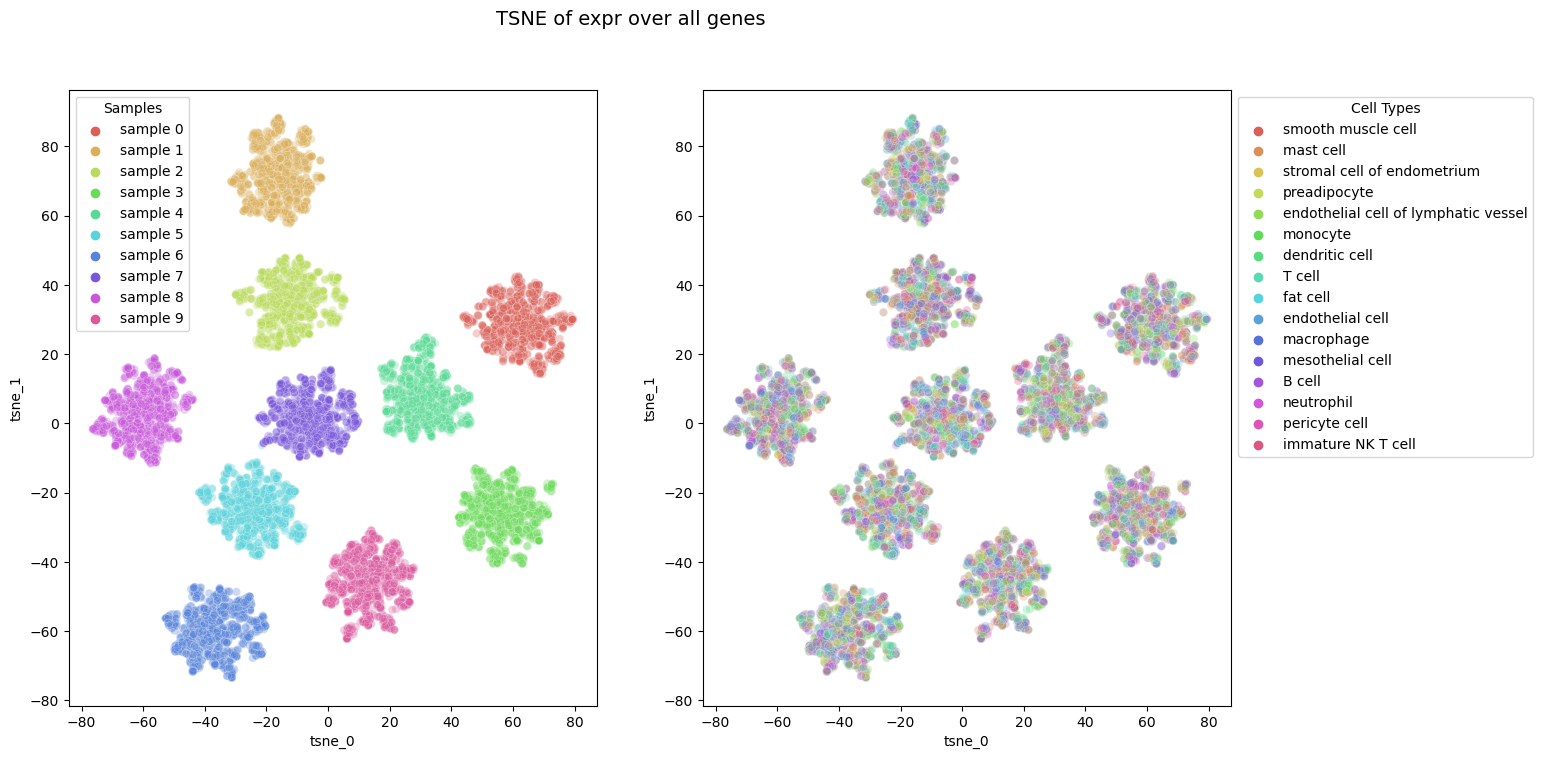

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15,8))

n_colors = len(np.unique(sample))
g = sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Samples",
    palette=sns.color_palette("hls", n_colors),
    legend="full",
    alpha=0.3,
    ax=axs[0]
)
#axs.set_title("title")
#palplot(colors, size=0.5, vertical=True, ax=axs[1]),

n_colors = len(np.unique(list(mx_prop)))
g = sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Cell Types",
    palette=sns.color_palette("hls", n_colors ),
    legend="full",
    alpha=0.5,
    ax=axs[1]
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

#axs.set_title("title")

fig.suptitle("TSNE of expr over all genes", fontsize=14)

## NNLS

In [4]:
df = adata.to_df()

NameError: name 'adata' is not defined

In [5]:
CellType_df = adata.obs["CellType"]

In [6]:
columns =  CellType_df.to_list()

In [7]:
df = df.T

In [8]:
df.columns = columns

In [9]:
df.head()

,preadipocyte,preadipocyte,macrophage,preadipocyte,fat cell,smooth muscle cell,fat cell,fat cell,mesothelial cell,preadipocyte,...,macrophage,macrophage,preadipocyte,preadipocyte,macrophage,mesothelial cell,preadipocyte,mesothelial cell,macrophage,fat cell
A1BG,0.00000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0
A1BG-AS1,0.00000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,1.98181,0.000000,0.0,0.0,0.000000,0.0
A1CF,0.00000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.00000,0.783472,0.0,0.0,0.000000,0.0
A2M,2.79202,0.0,1.22968,0.0,0.0,2.082247,1.170378,0.0,1.118466,0.0,...,1.927705,0.0,0.0,1.962901,0.00000,0.783472,0.0,0.0,2.257606,0.0
A2M-AS1,0.00000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0


In [10]:
colnames = df.columns.unique()
ref_df = pd.DataFrame()
for col in colnames:
    df_= df[col]
    df_ = df_.groupby(df_.columns, axis=1).mean()
    ref_df[col] = df_[col]

In [11]:
ref_df.head()

,preadipocyte,macrophage,fat cell,smooth muscle cell,mesothelial cell,stromal cell of endometrium,immature NK T cell,mast cell,endothelial cell of lymphatic vessel,endothelial cell,T cell,monocyte,B cell,dendritic cell,pericyte cell,neutrophil
A1BG,0.010951,0.012035,0.001338,0.034247,0.028703,0.012089,0.013981,0.024707,0.019782,0.001487,0.017216,0.008977,0.017727,0.016986,0.034987,0.000000
A1BG-AS1,0.017412,0.045266,0.002491,0.052531,0.064479,0.048221,0.028473,0.058206,0.027713,0.003749,0.047299,0.040004,0.043582,0.079057,0.071889,0.000000
A1CF,0.001288,0.000828,0.008270,0.002541,0.001170,0.000000,0.000000,0.000000,0.003942,0.002014,0.004186,0.000000,0.000000,0.001553,0.000000,0.000000
A2M,0.281333,0.852829,0.222679,1.202489,0.227447,0.400211,0.891465,1.434090,0.474587,1.581043,1.082802,0.264601,0.266204,0.754043,1.213265,0.291489
A2M-AS1,0.016311,0.013243,0.020905,0.019676,0.008963,0.013879,0.179807,0.370588,0.020039,0.037226,0.231956,0.017786,0.015121,0.021161,0.009903,0.026009


In [7]:
with open(f'{aug_data_path}/pbmc6k_processed_ref_df.pkl', 'rb') as f:
    # Load the Python object from the .pkl file
    ref_df = pickle.load(f)

In [12]:
with open(f'{aug_data_path}/pbmc6k_pseudobulk_samples.pkl', 'rb') as f:
    # Load the Python object from the .pkl file
    pseudobulk_df = pickle.load(f)
#pseudobulk_df.tail(5)    

In [13]:
pseudobulk_df.drop("samples", axis=1, inplace=True)

In [14]:
#samples = pseudobulk_df.columns
bulk_column = []
for sample in ["smaple1", "smaple2", "smaple3", "smaple4", "smaple5", "smaple6", "smaple7", "smaple8", "smaple9", "smaple10"]:
    for i in range(1000):
        bulk_column.append(sample+"_"+str(1+i))
 

In [15]:
pseudobulk_df = pseudobulk_df.T
pseudobulk_df.columns = bulk_column 
pseudobulk_df.shape

(29093, 10000)

In [8]:
## We are removing preadipocyte
#ref_df = ref_df.drop(['preadipocyte','macrophage'], axis=1)
ref_df.shape

(29093, 16)

## Proportion

In [52]:
proportions = {}
#residuals = pd.DataFrame()
for sample in pseudobulk_df:
    y = pseudobulk_df[sample]
    prop, _ = nnls(ref_df, y)
    proportions[sample] = prop    

In [16]:
index=ref_df.columns
ref_matrix = np.zeros((29093, 16))
ref_matrix = pd.DataFrame(ref_matrix)
ref_matrix.columns = ref_df.columns
for i in range(16):    
    proportions = {}
    #residuals = pd.DataFrame()
    for sample in pseudobulk_df:
        y = pseudobulk_df[sample]
        ref_matrix.iloc[:, 0:(1+i)] = ref_df.iloc[:, 0:(1+i)]
        #ref_df=ref_df.iloc[:,0:(1+i)]
        prop, _ = nnls(ref_matrix, y)
        proportions[sample] = prop 
    proportion_df = pd.DataFrame(proportions, index=index)
    
    adata_file = os.path.join(aug_data_path, f"{res_name}_proportion_df{i}.pkl")
    adata_path = Path(adata_file)
    pickle.dump(proportion_df, open(adata_path, "wb" ) )
    print(i)
    
   

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [3]:
with open(f'{aug_data_path}/pbmc6k_proportion_df.pkl', 'rb') as f:
    # Load the Python object from the .pkl file
    proportion_df = pickle.load(f)
#pseudobulk_df.tail(5)    

In [4]:
with open(f'{aug_data_path}/pbmc6k_proportion_mct_df.pkl', 'rb') as f:
    # Load the Python object from the .pkl file
    proportion_mct_df = pickle.load(f)
#pseudobulk_df.tail(5)    

In [5]:
bulkprops = {}
for col in proportion_df.columns:
    bulkprops[col] = list(proportion_df[col]/proportion_df[col].sum())

In [6]:
proportion_df = pd.DataFrame(bulkprops)

In [7]:
bulkprops = {}
for col in proportion_mct_df.columns:
    bulkprops[col] = list(proportion_mct_df[col]/proportion_mct_df[col].sum())

In [8]:
proportion_mct_df = pd.DataFrame(bulkprops)

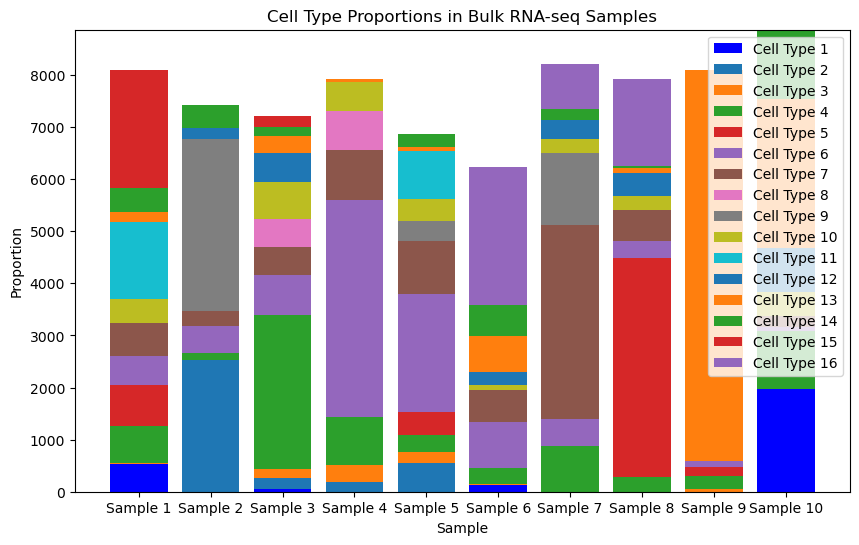

In [21]:
# Generate a stacked bar plot to visualize the proportions of each cell type in each sample
plt.figure(figsize=(10, 6))
plt.bar(np.arange(10), proportions.iloc[0, 0:10], label='Cell Type 1', color='b')
bottom = proportions.iloc[0, 0:10]
for i in range(1, 16):
    plt.bar(np.arange(10), proportions.iloc[i, 0:10], bottom=bottom, label='Cell Type {}'.format(i+1))
    bottom += proportions.iloc[i, 0:10]
plt.xticks(np.arange(10), ['Sample {}'.format(i+1) for i in range(10)])
plt.xlabel('Sample')
plt.ylabel('Proportion')
plt.title('Cell Type Proportions in Bulk RNA-seq Samples')
plt.legend()
plt.show()

<AxesSubplot:>

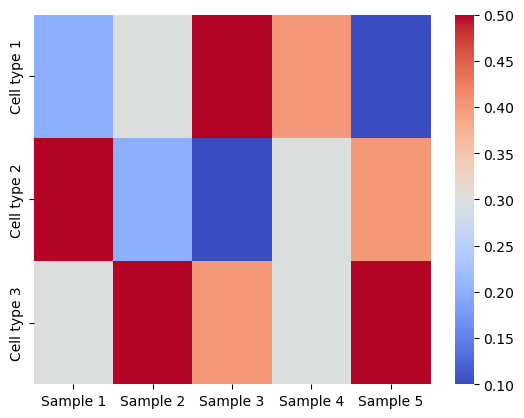

In [26]:
import numpy as np
import seaborn as sns

# X is the matrix of estimated cell type proportions
# Each column represents the proportions of cell types in a given sample
# Each row represents the proportions of a given cell type across all samples
# In this example, I assume X has 3 rows and 5 columns
X = np.array([[0.2, 0.3, 0.5, 0.4, 0.1],
              [0.5, 0.2, 0.1, 0.3, 0.4],
              [0.3, 0.5, 0.4, 0.3, 0.5]])

# Define the cell types and sample names
cell_types = ['Cell type 1', 'Cell type 2', 'Cell type 3']
sample_names = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5']

# Create a heatmap of the cell type proportions in each sample
sns.heatmap(X, cmap='coolwarm', xticklabels=sample_names, yticklabels=cell_types)

In [9]:
proportion_df = proportion_df.T
proportion_mct_df = proportion_mct_df.T
proportion_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
smaple1_1,0.066805,0.000000,0.000909,0.087671,0.098534,0.067963,0.078494,0.000000,0.000000,0.058075,0.182118,0.000000,0.023184,0.057748,0.278499,0.0
smaple1_2,0.000000,0.340432,0.000000,0.019393,0.000000,0.068973,0.038911,0.000000,0.444323,0.000000,0.000000,0.027384,0.000000,0.060584,0.000000,0.0
smaple1_3,0.007044,0.028761,0.024515,0.409435,0.000000,0.107174,0.074437,0.074913,0.000000,0.097031,0.000000,0.077544,0.047392,0.023757,0.027998,0.0
smaple1_4,0.000000,0.024075,0.039957,0.115988,0.000000,0.527134,0.120987,0.092395,0.000000,0.070734,0.000000,0.000000,0.008731,0.000000,0.000000,0.0
smaple1_5,0.000000,0.080868,0.029200,0.047761,0.065667,0.329383,0.148403,0.000000,0.054258,0.064209,0.133694,0.000000,0.011087,0.035470,0.000000,0.0


In [9]:
# Proportion
cell_props = pd.DataFrame(columns = ref_df.columns)
for  i in range(10):
    with open(f'{aug_data_path}/pbmc6kbulk_prop_{i}.pkl', 'rb') as f:
        # Load the Python object from the .pkl file
        cell_prop = pickle.load(f)
    cell_props = pd.concat([cell_props, cell_prop])
mx_prop = cell_prop.columns[np.argmax(cell_props.to_numpy(), axis=1)]

In [14]:
list(mx_prop)

['pericyte cell',
 'endothelial cell of lymphatic vessel',
 'smooth muscle cell',
 'stromal cell of endometrium',
 'stromal cell of endometrium',
 'neutrophil',
 'immature NK T cell',
 'mesothelial cell',
 'B cell',
 'B cell',
 'B cell',
 'immature NK T cell',
 'preadipocyte',
 'immature NK T cell',
 'mesothelial cell',
 'dendritic cell',
 'monocyte',
 'mast cell',
 'monocyte',
 'dendritic cell',
 'mast cell',
 'macrophage',
 'preadipocyte',
 'B cell',
 'dendritic cell',
 'fat cell',
 'stromal cell of endometrium',
 'neutrophil',
 'dendritic cell',
 'macrophage',
 'macrophage',
 'preadipocyte',
 'T cell',
 'endothelial cell',
 'B cell',
 'endothelial cell of lymphatic vessel',
 'endothelial cell of lymphatic vessel',
 'preadipocyte',
 'mesothelial cell',
 'mesothelial cell',
 'endothelial cell of lymphatic vessel',
 'endothelial cell',
 'mesothelial cell',
 'preadipocyte',
 'T cell',
 'monocyte',
 'B cell',
 'B cell',
 'fat cell',
 'immature NK T cell',
 'endothelial cell',
 'mast cell

In [ ]:
mx = pd.DataFrame()

In [13]:
cell_props.head()

,preadipocyte,macrophage,fat cell,smooth muscle cell,mesothelial cell,stromal cell of endometrium,immature NK T cell,mast cell,endothelial cell of lymphatic vessel,endothelial cell,T cell,monocyte,B cell,dendritic cell,pericyte cell,neutrophil
0,0.057,0.0032,0.0184,0.0118,0.1366,0.015,0.0008,0.036,0.0028,0.0164,0.2594,0.0414,0.0208,0.0178,0.359,0.0036
0,0.0256,0.369,0.001,0.001,0.0004,0.0098,0.0012,0.0006,0.495,0.0028,0.0024,0.0714,0.0106,0.0056,0.0,0.0036
0,0.024,0.0036,0.039,0.3024,0.0252,0.051,0.0116,0.1412,0.0182,0.058,0.0196,0.1138,0.0364,0.0034,0.1156,0.037
0,0.0028,0.0004,0.0524,0.0672,0.0648,0.4058,0.0604,0.1628,0.0036,0.0434,0.0268,0.0076,0.0114,0.0028,0.063,0.0248
0,0.0196,0.0776,0.042,0.0068,0.1034,0.2246,0.0618,0.007,0.0878,0.0054,0.2202,0.0098,0.0182,0.0158,0.068,0.032


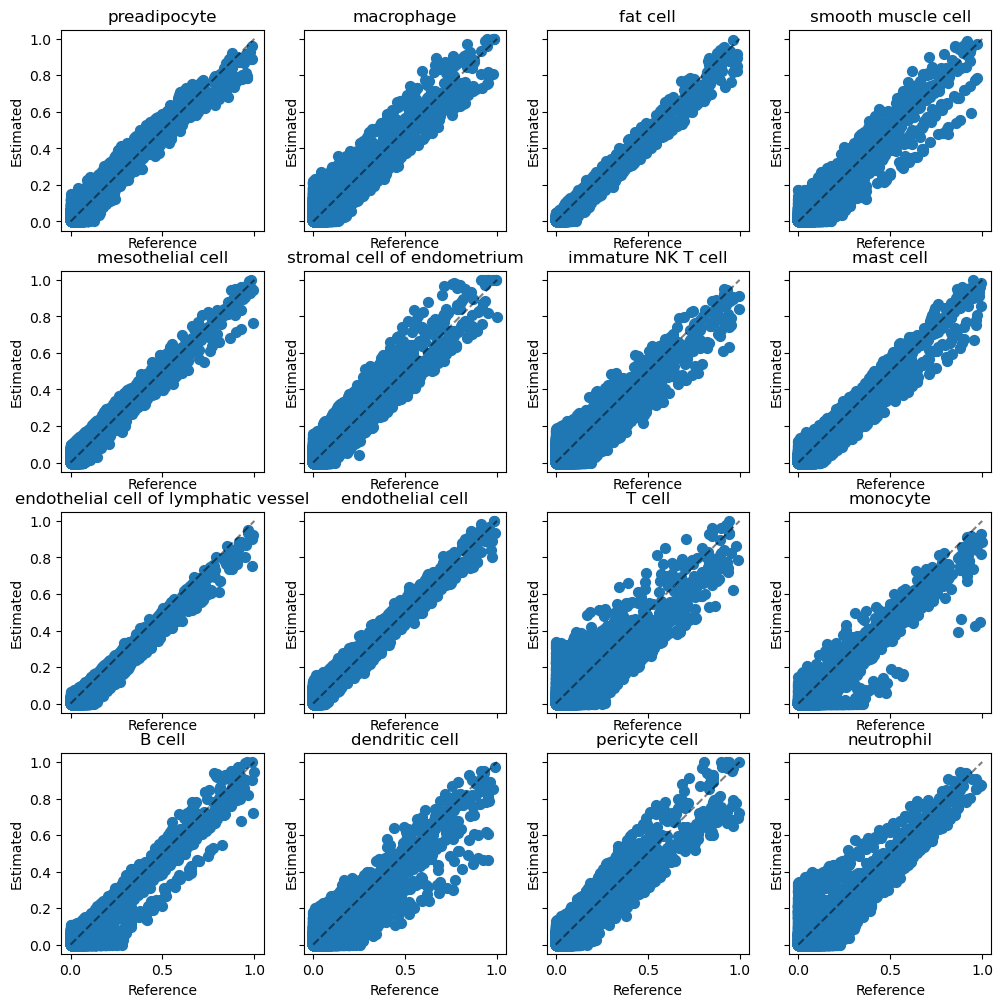

In [14]:
#fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), sharex=True, sharey=True)

#axs[1].scatter(proportion_df.T.iloc[:, 1], cell_props.iloc[:, 1], s=50)
sample_names=cell_props.columns

# plot data in each subplot
for i, ax in enumerate(ax.flatten()):
    ax.scatter(cell_props.iloc[:, i], proportion_df.iloc[:, i], s=50)
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax.set_title(f"Plot {i+1}")
    ax.set_title(sample_names[i])
    ax.set_xlabel('Reference')
    ax.set_ylabel('Estimated')
    #ax.set_xlim([0, 10])
    #ax.set_ylim([0, 1000])
#fig.suptitle('Cell type proportion comparison')

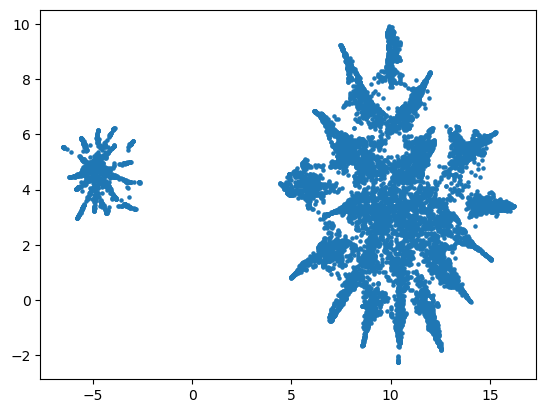

In [30]:
import plotly.express as px
from sklearn.datasets import load_digits
from umap import UMAP

digits = load_digits()

umap_2d = UMAP(random_state=0)
umap_2d.fit(proportions.T)

projections = umap_2d.transform(proportions.T)


plt.scatter(projections[:, 0], projections[:, 1], s= 5, cmap='Spectral')

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tsne = TSNE(n_components=2, verbose=0, perplexity=40, init="pca", learning_rate='auto')
    tsne_results = tsne.fit_transform(scale(np.log2(proportion_df.astype(float)+1.0), axis=1))

plot_df = pd.DataFrame(tsne_results)
print(tsne_results.shape)
print(plot_df.shape)

(10000, 2)
(10000, 2)


In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tsne = TSNE(n_components=2, verbose=0, perplexity=40, init="pca", learning_rate='auto')
    tsne_results = tsne.fit_transform(scale(np.log2(proportion_mct_df.astype(float)+1.0), axis=1))

plot_df1 = pd.DataFrame(tsne_results)
print(tsne_results.shape)
print(plot_df1.shape)

(10000, 2)
(10000, 2)


In [17]:
plot_df.columns = ['tsne_0', 'tsne_1']
plot_df1.columns = ['tsne_0', 'tsne_1']

In [20]:
plot_df['Cell Types'] = list(mx_prop)
mx_prop_m= [ 'Missing1' if x=="preadipocyte" else x for x in list(mx_prop)] 
mx_prop_m= [ 'Missing2' if x=='macrophage' else x for x in list(mx_prop_m)] 
plot_df1['Cell Types'] = mx_prop_m

/projects/ssadeeq@xsede.org/software/anaconda/envs/tf_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


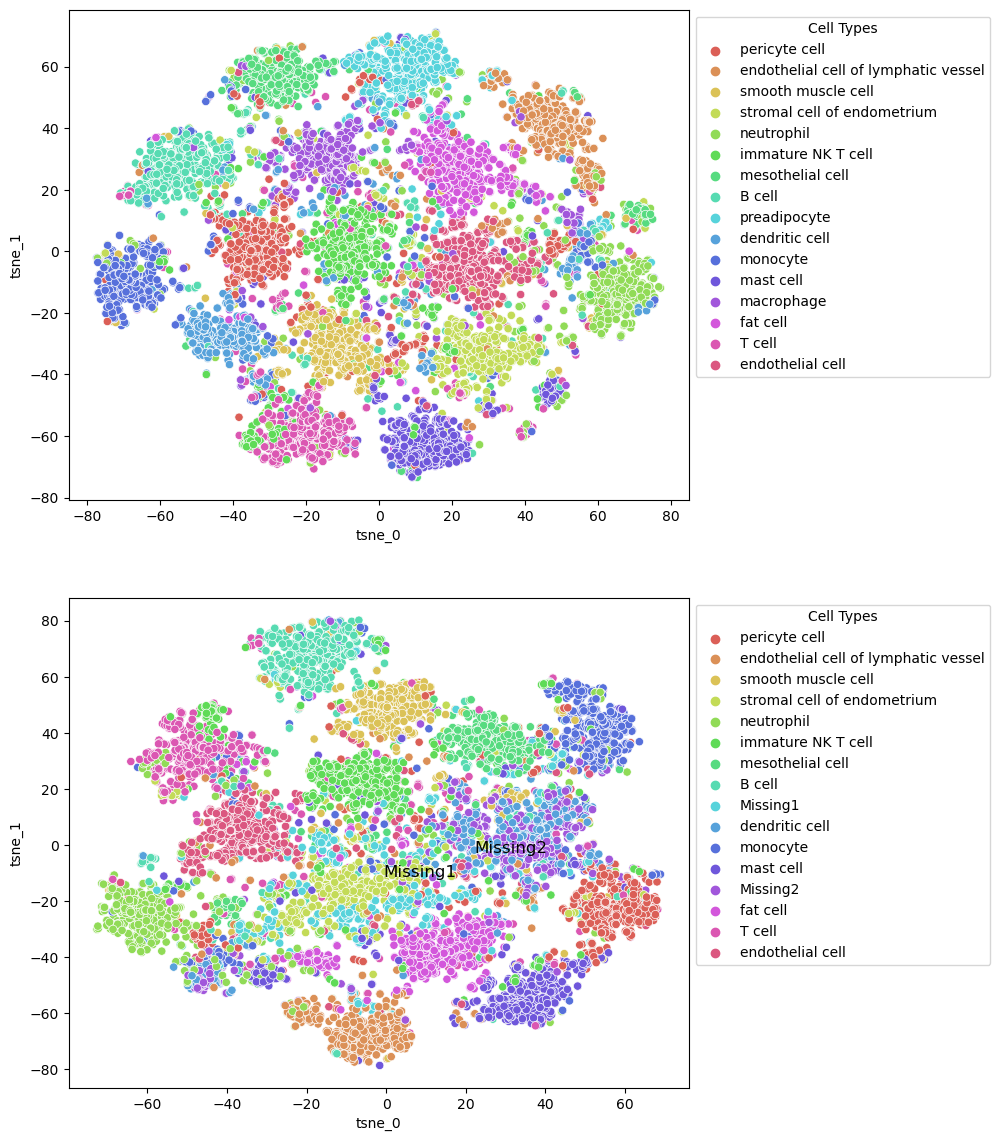

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(8,14))
n_colors = len(np.unique(mx_prop))
g = sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Cell Types",
    palette=sns.color_palette("hls", n_colors),
    legend="full",
    alpha=1,
    ax=axs[0]
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))


n_colors = len(np.unique(mx_prop_m))
g = sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df1,
    hue="Cell Types",
    palette=sns.color_palette("hls", n_colors),
    legend="full",
    alpha=1,
    ax=axs[1]
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))




for i in ["Missing1", "Missing2"]:
    cluster_mean = np.mean(plot_df1[plot_df1['Cell Types'] == i], axis=0)
    plt.text(cluster_mean[0], cluster_mean[1], '{}'.format(i),
             fontsize=12, color='black')
plt.show()